In [1]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

unable to import 'smart_open.gcs', disabling that module


# Pipeline

### Data Loader

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        head, tail = np.random.choice(nodes, 2)
        if head != tail and (head, tail) not in true_edges and (head, tail) not in false_edges:
            false_edges.add((head, tail))    
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]['weight'])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'] / p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]['weight'] / q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

def generate_first_order_random_walk(graph, alias_nodes, walk_length=10, start_node=None):
    """
    simulate a random walk starting from start node and considering the first order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else:
            break

    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, walk_length=10, start_node=None):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            break

    return walk

### Network Embedding Algorithms

In [5]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("trainig time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("trainig time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [6]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    pre_score = y_score
    
    return roc_auc_score(y_true, y_score)

# Link Prediction

In [7]:
train_file = "data/train.csv"
train_edges = load_data(train_file)

valid_file = "data/valid.csv"
valid_edges = load_data(valid_file)

- Combine train/valid edges

In [8]:
edges = train_edges+valid_edges

- Set parameters

In [9]:
np.random.seed(0)

node_dim = 10
num_walks = 10  
walk_length = 10 
p = 0.5
q = 0.5

deepwalk_auc_scores = list()
node2vec_auc_scores = list()

In [10]:
# generate the same validation size of false edges
false_edges = generate_false_edges(edges, num_false_edges=40000-len(valid_edges))

# construct the graph and preprocess transition probabilities
graph = construct_graph_from_edges(train_edges)

- Save the valid_ans.csv

In [11]:
valid_ans = valid_edges + false_edges

In [12]:
def write_predictions(file_name, src, dst, score):
    d = {'src': src, 'dst': dst, 'score': score}
    df = pd.DataFrame(d)
    df.to_csv(file_name, index=False)

In [13]:
src = list()
dst = list()
score = [1] * len(valid_edges) + [0] * len(false_edges)
for e in valid_ans:
    src.append(e[0])
    dst.append(e[1])

In [14]:
write_predictions('valid_ans.csv', src, dst, score)

- Run the model prediction

In [77]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

In [91]:
# build models and get auc scores
model_deepwalk = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
deepwalk_auc_scores.append(get_auc_score(model_deepwalk, valid_edges, false_edges))
    
model_node2vec = build_node2vec(graph, alias_nodes, alias_edges,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
node2vec_auc_scores.append(get_auc_score(model_node2vec, valid_edges, false_edges))
    
deepwalk_auc_scores = np.array(deepwalk_auc_scores)
node2vec_auc_scores = np.array(node2vec_auc_scores)

building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 19.1692
building a node2vec model...	number of walks: 83470	average walk length: 9.0835	trainig time: 18.3940


In [92]:
print("DeepWalk: auc score: ")  
print(deepwalk_auc_scores[0])
print("node2vec:  auc score: ")   
print(node2vec_auc_scores[0])

DeepWalk: auc score: 
0.9246221631148221
node2vec:  auc score: 
0.925648153740825


- Save valid_pred.csv

In [143]:
write_predictions('valid_pred.csv', src, dst, pre_score)

# Parameter tuning

- p,q

In [99]:
np.random.seed(0)

node_dim = 10
num_walks = 10  
walk_length = 10 
p_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
q_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

deepwalk_auc_scores = list()
node2vec_auc_scores = list()

# generate the same validation size of false edges
false_edges = generate_false_edges(edges, num_false_edges=40000-len(valid_edges))

# construct the graph and preprocess transition probabilities
graph = construct_graph_from_edges(train_edges)

for p in p_list:
    
    deepwalk_scores = list()
    node2vec_scores = list()
    
    for q in q_list:
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

        # build models and get auc scores
        model_deepwalk = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_scores.append(get_auc_score(model_deepwalk, valid_edges, false_edges))
    
        model_node2vec = build_node2vec(graph, alias_nodes, alias_edges,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_scores.append(get_auc_score(model_node2vec, valid_edges, false_edges))
    
    deepwalk_auc_scores.append(deepwalk_scores)
    node2vec_auc_scores.append(node2vec_scores)
    
deepwalk_auc_scores = np.array(deepwalk_auc_scores)
node2vec_auc_scores = np.array(node2vec_auc_scores)

number of nodes: 8347
number of edges: 100000
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.9151
building a node2vec model...	number of walks: 83470	average walk length: 9.0718	trainig time: 18.8858
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.0295
building a node2vec model...	number of walks: 83470	average walk length: 9.0916	trainig time: 18.2372
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.3145
building a node2vec model...	number of walks: 83470	average walk length: 9.0971	trainig time: 23.8281
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.5704
building a node2vec model...	number of walks: 83470	average walk length: 9.1081	trainig time: 19.1104
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 21.4522
building a node2vec model...	number 

building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.0686
building a node2vec model...	number of walks: 83470	average walk length: 9.0576	trainig time: 18.5680
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.1704
building a node2vec model...	number of walks: 83470	average walk length: 9.0674	trainig time: 18.7483
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.5636
building a node2vec model...	number of walks: 83470	average walk length: 9.0762	trainig time: 18.4347
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.1559
building a node2vec model...	number of walks: 83470	average walk length: 9.0764	trainig time: 18.6899
building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 18.0623
building a node2vec model...	number of walks: 83470	average walk length: 9.0835	tr

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

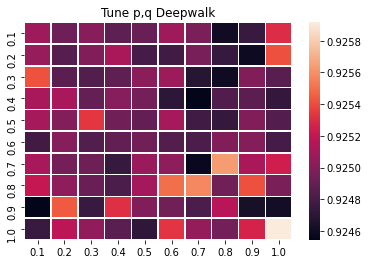

In [107]:
ax_deepwalk = sns.heatmap(deepwalk_auc_scores, linewidth=0.5, xticklabels=q_list, yticklabels=p_list)
ax_deepwalk.set_title("Tune p,q Deepwalk")
plt.show()

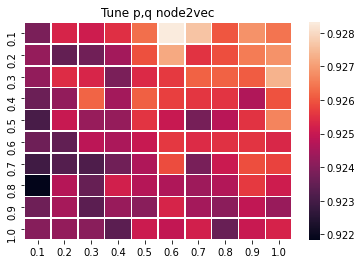

In [108]:
ax_node2vec = sns.heatmap(node2vec_auc_scores, linewidth=0.5, xticklabels=q_list, yticklabels=p_list)
ax_node2vec.set_title("Tune p,q node2vec")
plt.show()

- num_walks / walk_length

In [109]:
## For Deepwalk model
np.random.seed(0)

node_dim = 10
num_walks_list = [10,15,20,25,30]  # 10-30
walk_length_list =[10,15,20,25,30]  # 10-30
p = 1.0
q = 1.0

deepwalk_auc_scores = list()

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

for num_walks in num_walks_list:
    
    deepwalk_scores = list()
    
    for walk_length in walk_length_list:
        
        # build models and get auc scores
        model_deepwalk = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_scores.append(get_auc_score(model_deepwalk, valid_edges, false_edges))
    
    
    deepwalk_auc_scores.append(deepwalk_scores)
    
deepwalk_auc_scores = np.array(deepwalk_auc_scores)

building a DeepWalk model...	number of walks: 83470	average walk length: 9.0894	trainig time: 22.3993
building a DeepWalk model...	number of walks: 83470	average walk length: 13.4127	trainig time: 28.5518
building a DeepWalk model...	number of walks: 83470	average walk length: 17.6472	trainig time: 35.6653
building a DeepWalk model...	number of walks: 83470	average walk length: 21.7593	trainig time: 42.5877
building a DeepWalk model...	number of walks: 83470	average walk length: 25.7928	trainig time: 55.5147
building a DeepWalk model...	number of walks: 125205	average walk length: 9.0864	trainig time: 25.8593
building a DeepWalk model...	number of walks: 125205	average walk length: 13.4104	trainig time: 44.6126
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 56.1777
building a DeepWalk model...	number of walks: 125205	average walk length: 21.7568	trainig time: 69.8039
building a DeepWalk model...	number of walks: 125205	average walk lengt

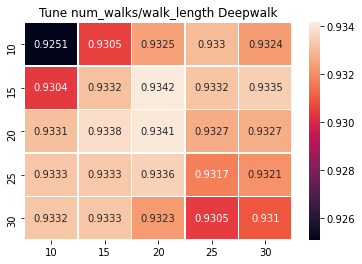

In [112]:
ax_deepwalk_2 = sns.heatmap(deepwalk_auc_scores,annot=True,fmt='.4g', linewidth=0.5, xticklabels=walk_length_list, yticklabels=num_walks_list)
ax_deepwalk_2.set_title("Tune num_walks/walk_length Deepwalk")
plt.show()

In [113]:
## For node2vec model
np.random.seed(0)

node_dim = 10
num_walks_list = [10,15,20,25,30]  # 10-30
walk_length_list =[10,15,20,25,30]  # 10-30
p = 0.1
q = 0.6

node2vec_auc_scores = list()

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

for num_walks in num_walks_list:
    
    node2vec_scores = list()
    
    for walk_length in walk_length_list:
        
        # build models and get auc scores
        model_node2vec = build_node2vec(graph, alias_nodes, alias_edges,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_scores.append(get_auc_score(model_node2vec, valid_edges, false_edges))
    
    
    node2vec_auc_scores.append(node2vec_scores)
    
node2vec_auc_scores = np.array(node2vec_auc_scores)

building a node2vec model...	number of walks: 83470	average walk length: 9.1194	trainig time: 21.2057
building a node2vec model...	number of walks: 83470	average walk length: 13.4894	trainig time: 30.5670
building a node2vec model...	number of walks: 83470	average walk length: 17.7569	trainig time: 37.6256
building a node2vec model...	number of walks: 83470	average walk length: 21.9401	trainig time: 52.9797
building a node2vec model...	number of walks: 83470	average walk length: 26.0209	trainig time: 57.6160
building a node2vec model...	number of walks: 125205	average walk length: 9.1183	trainig time: 28.0697
building a node2vec model...	number of walks: 125205	average walk length: 13.4846	trainig time: 44.3527
building a node2vec model...	number of walks: 125205	average walk length: 17.7566	trainig time: 51.0496
building a node2vec model...	number of walks: 125205	average walk length: 21.9394	trainig time: 68.7102
building a node2vec model...	number of walks: 125205	average walk lengt

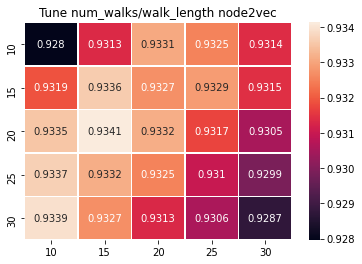

In [114]:
ax_node2vec_2 = sns.heatmap(node2vec_auc_scores, annot=True, fmt='.4g', linewidth=0.5, xticklabels=walk_length_list, yticklabels=num_walks_list)
ax_node2vec_2.set_title("Tune num_walks/walk_length node2vec")
plt.show()

- Final adjustment: DeepWalk

In [34]:
np.random.seed(0)

node_dim = 10
num_walks = 15  
walk_length = 20 
p_list = [0.6,0.7,0.8,0.9,1.0]
q_list = [0.6,0.7,0.8,0.9,1.0]

deepwalk_auc_scores = list()

for p in p_list:
    
    deepwalk_scores = list()
    
    for q in q_list:
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

        # build models and get auc scores
        model_deepwalk = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_scores.append(get_auc_score(model_deepwalk, valid_edges, false_edges))
    
    deepwalk_auc_scores.append(deepwalk_scores)
    
deepwalk_auc_scores = np.array(deepwalk_auc_scores)

building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 50.2957
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 56.3030
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 55.2976
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 54.6571
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 52.7521
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 57.8562
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 52.2092
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 49.9793
building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 57.8034
building a DeepWalk model...	number of walks: 125205	average wal

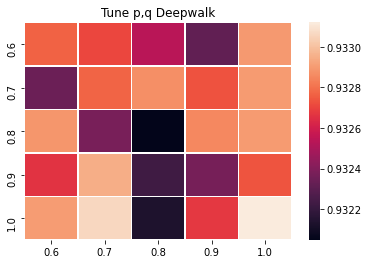

In [35]:
ax_deepwalk = sns.heatmap(deepwalk_auc_scores, linewidth=0.5, xticklabels=q_list, yticklabels=p_list)
ax_deepwalk.set_title("Tune p,q Deepwalk")
plt.show()

- Final adjustment: Node2Vec

In [19]:
np.random.seed(0)

node_dim = 10
num_walks = 20  
walk_length = 15 
p_list = [0.1,0.2,0.3,0.4,0.5]
q_list = [0.6,0.7,0.8,0.9,1.0]

node2vec_auc_scores = list()

for p in p_list:
    
    node2vec_scores = list()
    
    for q in q_list:
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

        # build models and get auc scores
        model_node2vec = build_node2vec(graph, alias_nodes, alias_edges,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_scores.append(get_auc_score(model_node2vec, valid_edges, false_edges))
    
    
    node2vec_auc_scores.append(node2vec_scores)
    
node2vec_auc_scores = np.array(node2vec_auc_scores)

building a node2vec model...	number of walks: 166940	average walk length: 13.4839	trainig time: 50.8250
building a node2vec model...	number of walks: 166940	average walk length: 13.5013	trainig time: 49.9165
building a node2vec model...	number of walks: 166940	average walk length: 13.4970	trainig time: 57.4324
building a node2vec model...	number of walks: 166940	average walk length: 13.5132	trainig time: 50.1158
building a node2vec model...	number of walks: 166940	average walk length: 13.5147	trainig time: 49.7539
building a node2vec model...	number of walks: 166940	average walk length: 13.4373	trainig time: 56.9756
building a node2vec model...	number of walks: 166940	average walk length: 13.4575	trainig time: 50.4950
building a node2vec model...	number of walks: 166940	average walk length: 13.4669	trainig time: 50.2633
building a node2vec model...	number of walks: 166940	average walk length: 13.4715	trainig time: 50.5327
building a node2vec model...	number of walks: 166940	average wal

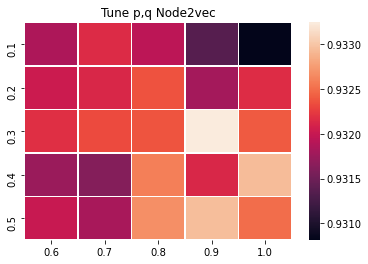

In [20]:
ax_node2vec = sns.heatmap(node2vec_auc_scores, linewidth=0.5, xticklabels=q_list, yticklabels=p_list)
ax_node2vec.set_title("Tune p,q Node2vec")
plt.show()

# Final Model

## Deepwalk model

In [15]:
np.random.seed(0)

node_dim = 10
num_walks = 15
walk_length = 20
p = 0.9
q = 0.9

In [16]:
# generate the same validation size of false edges
false_edges = generate_false_edges(edges, num_false_edges=40000-len(valid_edges))

# construct the graph and preprocess transition probabilities
graph = construct_graph_from_edges(train_edges)

number of nodes: 8347
number of edges: 100000


In [17]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

# build models and get auc scores
model_deepwalk = build_deepwalk(graph, alias_nodes,
                            node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
deepwalk_auc_score = get_auc_score(model_deepwalk, valid_edges, false_edges)

print("DeepWalk: auc score: %.4f" %(deepwalk_auc_score )) 

building a DeepWalk model...	number of walks: 125205	average walk length: 17.6439	trainig time: 57.4633
DeepWalk: auc score: 0.9321


In [18]:
def get_pred_score(model, true_edges, false_edges):
   
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return y_score

In [19]:
pre_score = get_pred_score(model_deepwalk, valid_edges, false_edges)

In [20]:
write_predictions('valid_pred.csv', src, dst, pre_score)

# AUC Score

In [21]:
ans = pd.read_csv("data/valid_ans.csv", usecols=["src", "dst", "score"])
pred = pd.read_csv(r"data/valid_pred.csv", usecols=["src", "dst", "score"])
df = pd.merge(ans, pred, how="left", on=["src", "dst"])
df.fillna(0, inplace=True)
auc_score = roc_auc_score(df["score_x"], df["score_y"])
print("auc score:", auc_score)

auc score: 0.926213494799093


# Write Prediction on Testing data

In [166]:
test = pd.read_csv("data/test.csv")
test = test.drop(columns="score")

In [167]:
test_edges = list(test.to_records(index=False))

In [170]:
def get_test_score(model, test_edges):
   
    y_score = list()
    for e in test_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return y_score

In [171]:
pre_score = get_test_score(model_deepwalk, test_edges)

In [185]:
write_predictions('test_pred.csv', list(test["src"]), list(test["dst"]), pre_score)